In [9]:
import sys
import os

# 添加 factor_evaluation.pyd 所在的目录到系统路径
pyd_path = r"D:\MG\！internship\！4L CAPITAL\因子评估器"
sys.path.append(pyd_path)

# 导入模块
from factor_evaluation import FactorEvaluation
from factor_evaluation import DataService
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta
import matplotlib.pyplot as plt

In [10]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [11]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [12]:
def rsrs_beta_r2_factor(df, window_N=16):
    """
    高效计算RSRS_beta和R-squared
    """
    low = df['low']
    high = df['high']
    n = len(df)
    
    # 预分配数组
    beta = np.full(n, np.nan)
    r_squared = np.full(n, np.nan)
    
    # 预计算滚动统计量
    low_mean = low.rolling(window_N).mean()
    high_mean = high.rolling(window_N).mean()
    low_var = low.rolling(window_N).var(ddof=1)
    cov = low.rolling(window_N).cov(high)
    
    # 使用向量化计算
    for i in range(window_N-1, n):
        if low_var[i] < 1e-5:  # 避免除以零
            beta[i] = 0
            r_squared[i] = 0
            continue
            
        beta[i] = cov[i] / low_var[i]
        
        # 计算R-squared
        y = high.iloc[i-window_N+1:i+1].values
        y_pred = low.iloc[i-window_N+1:i+1].values * beta[i] + (high_mean[i] - beta[i]*low_mean[i])
        ss_res = np.sum((y - y_pred)**2)
        ss_tot = np.sum((y - high_mean[i])**2)
        r_squared[i] = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    beta_series = pd.Series(beta, index=df.index).ffill().fillna(0)
    r2_series = pd.Series(r_squared, index=df.index).ffill().fillna(0)
    return beta_series, r2_series

def rsrs_beta_factor(df, window_N=16):
    """使用高效版本计算基础RSRS beta"""
    beta, _ = rsrs_beta_r2_factor(df, window_N)
    return beta

def rsrs_zscore_factor(df, window_N=16, window_M=300):
    """高效计算标准分RSRS指标"""
    beta = rsrs_beta_factor(df, window_N)
    rolling_mean = beta.rolling(window_M, min_periods=1).mean()
    rolling_std = beta.rolling(window_M, min_periods=1).std().replace(0, 1e-5)
    return (beta - rolling_mean) / rolling_std

def rsrs_zscore_r2_factor(df, window_N=16, window_M=300):
    """高效计算修正标准分RSRS指标"""
    beta, r_squared = rsrs_beta_r2_factor(df, window_N)
    rolling_mean = beta.rolling(window_M, min_periods=1).mean()
    rolling_std = beta.rolling(window_M, min_periods=1).std().replace(0, 1e-5)
    return (beta - rolling_mean) / rolling_std * r_squared

def rsrs_zscore_positive_factor(df, window_N=16, window_M=300):
    """高效计算右偏标准分RSRS指标"""
    beta, r_squared = rsrs_beta_r2_factor(df, window_N)
    rolling_mean = beta.rolling(window_M, min_periods=1).mean()
    rolling_std = beta.rolling(window_M, min_periods=1).std().replace(0, 1e-5)
    return ((beta - rolling_mean) / rolling_std) * r_squared * beta

def rsrs_beta_weighted_factor(df, window_N=16):
    """高效计算加权回归的RSRS指标"""
    low = df['low']
    high = df['high']
    n = len(df)
    beta = np.full(n, np.nan)
    
    # 预计算权重
    weights = np.linspace(1, window_N, window_N)
    weights /= weights.sum()
    
    # 使用更安全的方式计算加权回归
    for i in range(window_N-1, n):
        # 获取窗口数据
        window_low = low.iloc[i-window_N+1:i+1].values
        window_high = high.iloc[i-window_N+1:i+1].values
        
        # 计算加权均值
        w_low_mean = np.dot(window_low, weights)
        w_high_mean = np.dot(window_high, weights)
        
        # 计算加权协方差和方差
        w_cov = np.dot(weights, (window_low - w_low_mean) * (window_high - w_high_mean))
        w_low_var = np.dot(weights, (window_low - w_low_mean)**2)
        
        # 计算beta
        if w_low_var < 1e-5:
            beta[i] = 0
        else:
            beta[i] = w_cov / w_low_var
    
    return pd.Series(beta, index=df.index).ffill().fillna(0)

def rsrs_zscore_blunt_factor(df, window_N=16, window_M=300, R=0.8):
    """高效计算钝化标准分RSRS指标"""
    beta = rsrs_beta_factor(df, window_N)
    rolling_mean = beta.rolling(window_M, min_periods=1).mean()
    rolling_std = beta.rolling(window_M, min_periods=1).std().replace(0, 1e-5)
    zscore = (beta - rolling_mean) / rolling_std
    
    # 计算波动率
    returns = df['close'].pct_change().fillna(0)
    vol = returns.rolling(window_N, min_periods=1).std()
    
    # 使用高效分位数计算
    vol_quantile = vol.rolling(window_M, min_periods=1).quantile(0.5)
    
    # 计算钝化因子
    blunt_factor = R ** (4 * vol_quantile)
    
    return zscore * blunt_factor

def optimize_weights(df, factors, target):
    """优化因子权重"""
    X = pd.DataFrame({name: factor(df) for name, factor in factors.items()})
    y = target(df)
    
    # 删除包含NaN的行
    valid_mask = X.notna().all(axis=1) & y.notna()
    X_valid = X[valid_mask]
    y_valid = y[valid_mask]
    
    if len(X_valid) == 0:
        return np.ones(len(factors)) / len(factors)  # 默认等权重
    
    model = LinearRegression()
    model.fit(X_valid, y_valid)
    return model.coef_

因子计算完成，长度: 130660
因子统计摘要:
count   130660.0000
mean         0.0000
std          1.0000
min         -2.5904
25%         -0.6783
50%         -0.0000
75%          0.6783
max          2.5904
dtype: float64

📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): -0.003101
   Rank_IC (Spearman): -0.027651
📊 信息比率:
   IR: 0.168518
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130650
   因子列: improved_factor_with_rsrs
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


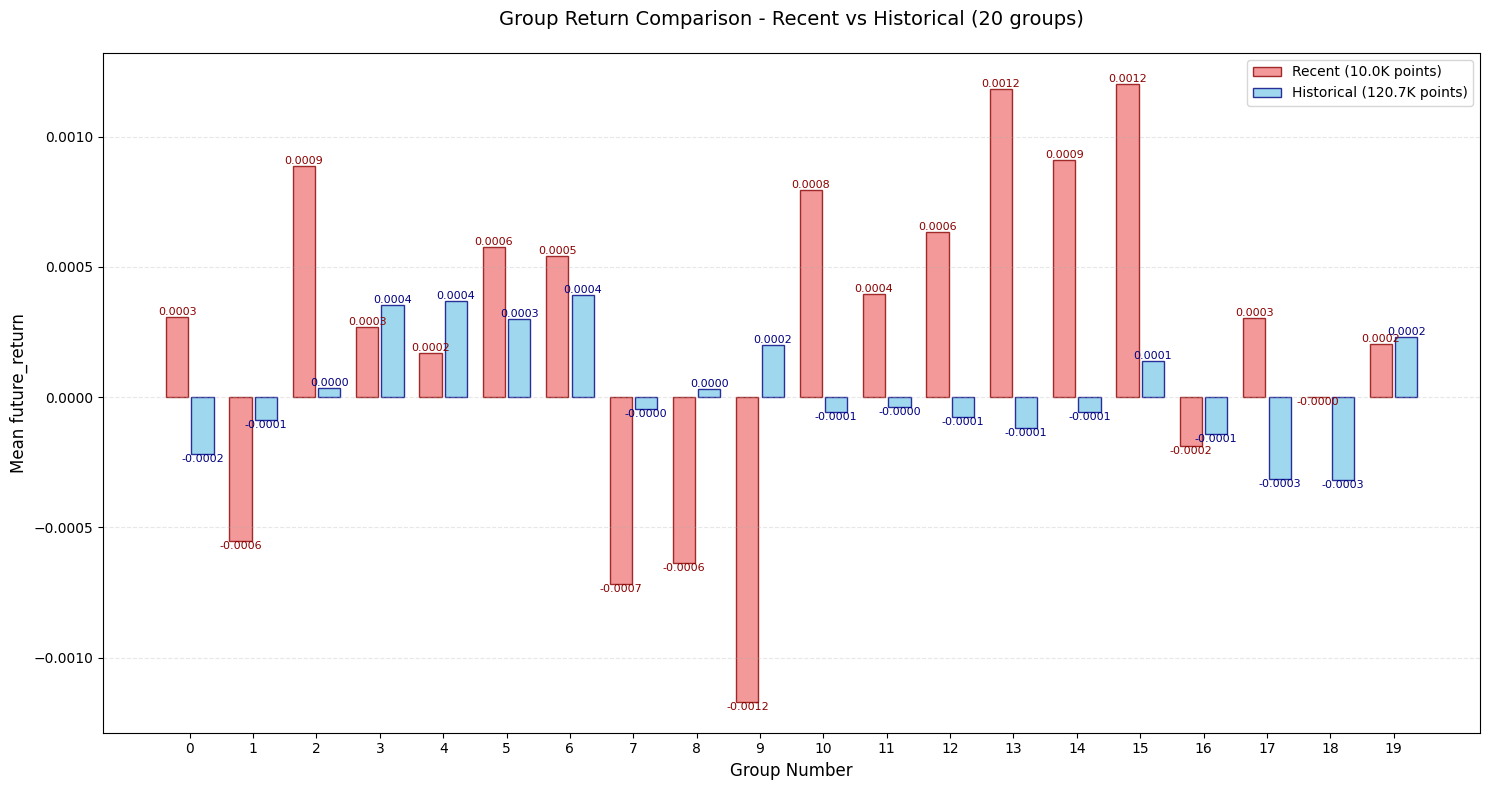

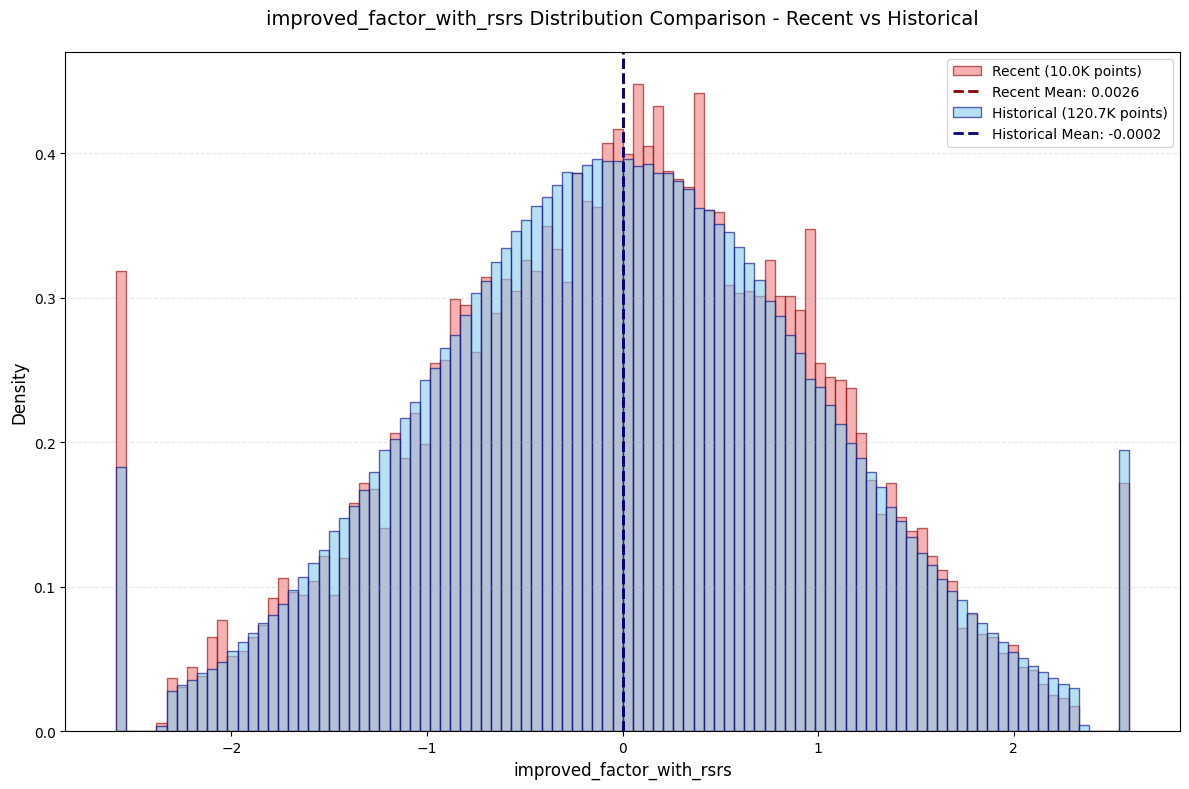

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------
发生错误: name 'analyze_factor_groups' is not defined

尝试使用简单RSRS因子作为后备方案...


Traceback (most recent call last):
  File "C:\Users\19927\AppData\Local\Temp\ipykernel_35680\1248673875.py", line 146, in <module>
    group_analysis = analyze_factor_groups(df, factor_series)
                     ^^^^^^^^^^^^^^^^^^^^^
NameError: name 'analyze_factor_groups' is not defined



📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): -0.004099
   Rank_IC (Spearman): -0.027885
📊 信息比率:
   IR: 0.355210
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130649
   因子列: simple_rsrs_zscore
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


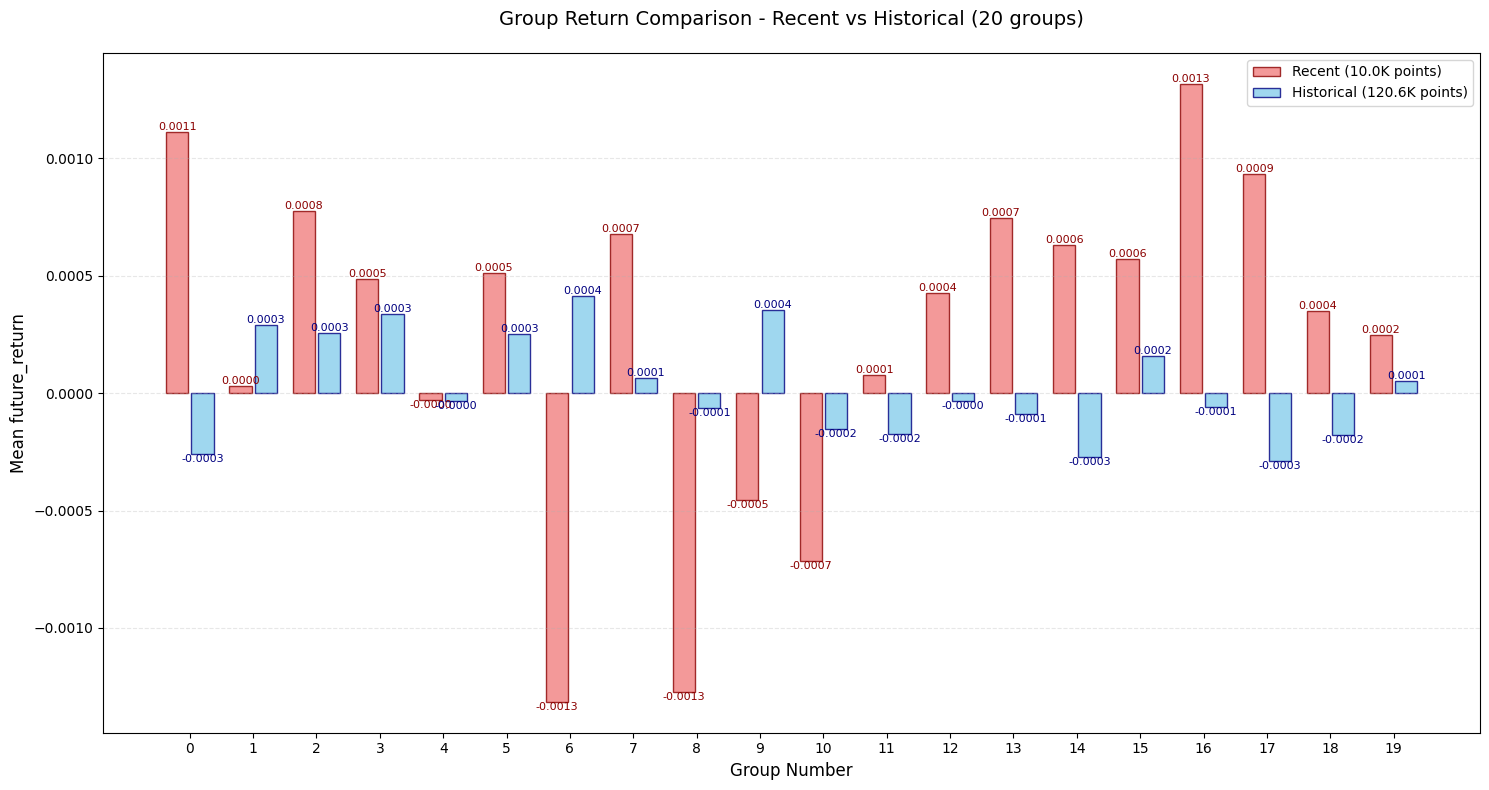

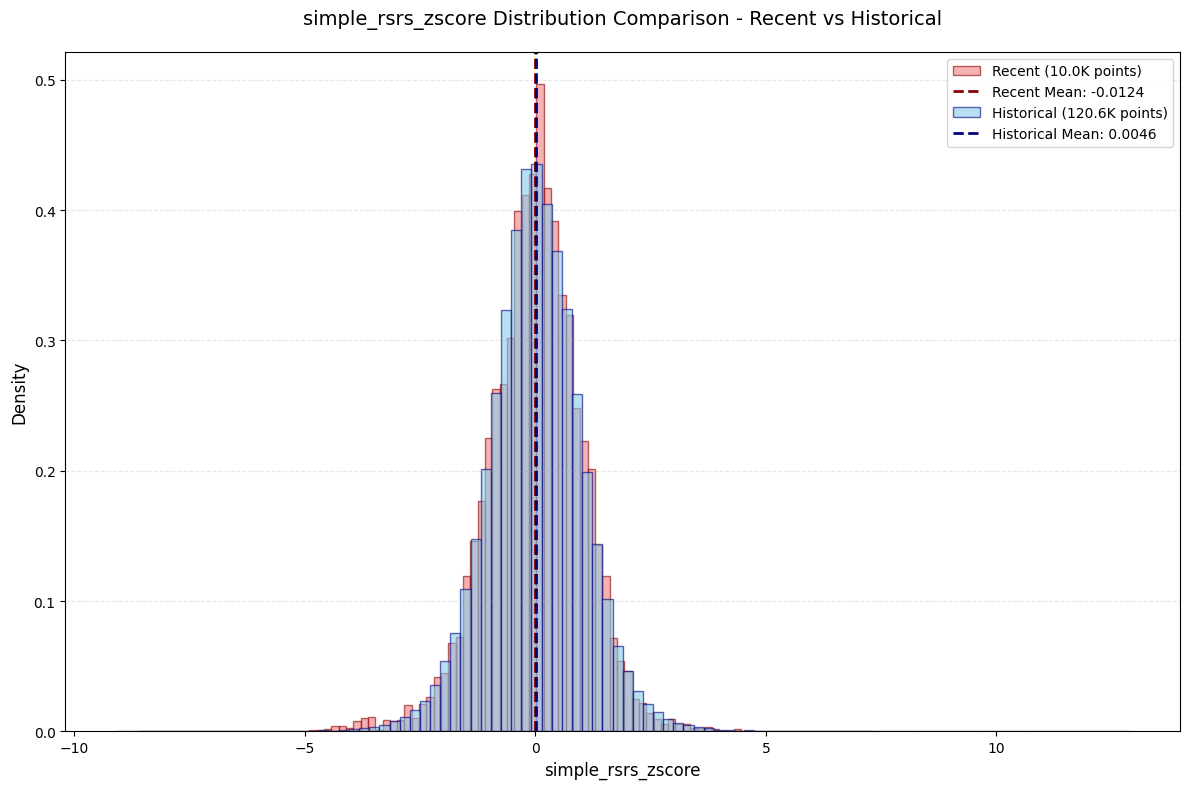

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [13]:
# ... [保留前面的导入和函数定义] ...

# 修改 improved_factor 函数
def improved_factor(df):
    """组合多个RSRS指标生成改进因子"""
    # 一次性计算基础beta和R-squared
    beta, r_squared = rsrs_beta_r2_factor(df, window_N=16)
    
    # 计算各个RSRS指标（避免重复计算）
    rsrs_zscore = rsrs_zscore_factor(df, window_N=16, window_M=300)
    rsrs_zscore_r2 = rsrs_zscore_r2_factor(df, window_N=16, window_M=300)
    rsrs_zscore_positive = rsrs_zscore_positive_factor(df, window_N=16, window_M=300)
    rsrs_beta_weighted = rsrs_beta_weighted_factor(df, window_N=16)
    rsrs_zscore_blunt = rsrs_zscore_blunt_factor(df, window_N=16, window_M=300, R=0.8)
    
    # 创建因子字典
    factors_dict = {
        'rsrs_beta': beta,
        'rsrs_zscore': rsrs_zscore,
        'rsrs_zscore_r2': rsrs_zscore_r2,
        'rsrs_zscore_positive': rsrs_zscore_positive,
        'rsrs_beta_weighted': rsrs_beta_weighted,
        'rsrs_zscore_blunt': rsrs_zscore_blunt
    }
    
    # 标准化所有因子
    standardized = {}
    for name, series in factors_dict.items():
        # 检查序列是否有效
        if series.nunique() < 2:  # 如果序列是常数
            standardized[name] = pd.Series(0, index=series.index)
            continue
            
        mean_val = series.mean()
        std_val = series.std()
        if std_val < 1e-5:
            standardized[name] = series - mean_val
        else:
            standardized[name] = (series - mean_val) / std_val
    
    # 组合因子
    combined_factor = pd.Series(0, index=df.index)
    for name, series in standardized.items():
        combined_factor += series
    
    # 最终归一化处理
    if combined_factor.nunique() > 1:  # 确保不是常数序列
        abs_mean = combined_factor.abs().rolling(50, min_periods=1).mean().clip(1e-5, None)
        combined_factor = combined_factor / abs_mean
    else:
        combined_factor = pd.Series(0, index=df.index)
    
    # ========================== 安全的数据处理 ==========================
    # 1. 确保因子值有效
    combined_factor = combined_factor.replace([np.inf, -np.inf], np.nan).ffill().fillna(0)
    
    # 2. 去极值处理 (Winsorization) - 确保有足够数据
    if len(combined_factor.dropna()) > 10:
        def winsorize(series, lower_percentile=1, upper_percentile=99):
            """对因子值进行去极值处理"""
            # 确保有足够数据点计算百分位数
            valid_series = series.dropna()
            if len(valid_series) < 10:
                return series
                
            lower_bound = np.percentile(valid_series, lower_percentile)
            upper_bound = np.percentile(valid_series, upper_percentile)
            return series.clip(lower_bound, upper_bound)
        
        winsorized_factor = winsorize(combined_factor, lower_percentile=1, upper_percentile=99)
    else:
        winsorized_factor = combined_factor
    
    # 3. 正态化处理 - 仅当有足够数据时
    if len(winsorized_factor.dropna()) > 100:
        def normalize_to_gaussian(series):
            """使用分位数映射将因子分布转换为正态分布"""
            from scipy.stats import norm, rankdata
            
            # 仅使用有效数据
            valid_series = series.dropna()
            if len(valid_series) < 10:
                return series
                
            # 计算秩百分比
            ranks = rankdata(valid_series, method='average')
            ranks_pct = (ranks - 0.5) / len(valid_series)
            
            # 避免极端值
            ranks_pct = np.clip(ranks_pct, 0.001, 0.999)
            
            # 映射到正态分布
            gaussian_values = norm.ppf(ranks_pct)
            
            # 创建结果序列
            result = pd.Series(np.nan, index=series.index)
            result.loc[valid_series.index] = gaussian_values
            return result.ffill().fillna(0)
        
        gaussian_factor = normalize_to_gaussian(winsorized_factor)
        
        # 重新标准化
        if gaussian_factor.nunique() > 1:
            mean_val = gaussian_factor.mean()
            std_val = gaussian_factor.std()
            if std_val > 1e-5:
                gaussian_factor = (gaussian_factor - mean_val) / std_val
        else:
            gaussian_factor = gaussian_factor - gaussian_factor.mean()
    else:
        gaussian_factor = winsorized_factor
    
    # 确保最终结果有效
    gaussian_factor = gaussian_factor.replace([np.inf, -np.inf], np.nan).ffill().fillna(0)
    
    # 返回处理后的因子
    return gaussian_factor

# %%
# 计算因子值
try:
    factor_series = improved_factor(df)
    print(f"因子计算完成，长度: {len(factor_series)}")
    print(f"因子统计摘要:\n{factor_series.describe()}")
    
    # 检查因子值是否有效
    if factor_series.isna().any():
        print("警告: 因子值包含NaN，将填充为0")
        factor_series = factor_series.fillna(0)
    
    if factor_series.isnull().any():
        print("警告: 因子值包含Null，将填充为0")
        factor_series = factor_series.fillna(0)
    
    evaluator.set_factor(
        factor_data_or_func=factor_series,
        factor_name='improved_factor_with_rsrs'
    )
    
    result = evaluator.run_full_evaluation(run_stationarity_test=False)
    
    # 手动查看分组数据
    if 'future_return' not in df.columns:
        df['future_return'] = df['close'].pct_change(10).shift(-10)
    
    group_analysis = analyze_factor_groups(df, factor_series)
    
    # 运行剔除极端值后的评估
    filtered_result = evaluate_without_extremes(df, factor_series)
    
except Exception as e:
    print(f"发生错误: {e}")
    import traceback
    traceback.print_exc()
    
    # 使用简单因子作为后备方案
    print("\n尝试使用简单RSRS因子作为后备方案...")
    simple_factor = rsrs_zscore_factor(df, window_N=16, window_M=300)
    evaluator.set_factor(
        factor_data_or_func=simple_factor,
        factor_name='simple_rsrs_zscore'
    )
    result = evaluator.run_full_evaluation(run_stationarity_test=False)

# %%
# 添加分组分析函数（与之前相同）
def analyze_factor_groups(df, factor_series, future_return_col='future_return', num_groups=20):
    """手动分析因子分组表现"""
    # 确保数据对齐
    analysis_df = pd.DataFrame({
        'factor': factor_series,
        'future_return': df[future_return_col]
    }).dropna()
    
    # 检查是否有足够数据
    if len(analysis_df) < num_groups * 2:
        print(f"警告: 数据不足 ({len(analysis_df)} 个样本)，无法进行 {num_groups} 组分析")
        return None
    
    # 按因子值分组
    try:
        analysis_df['group'] = pd.qcut(
            analysis_df['factor'], 
            q=num_groups,
            labels=False,
            duplicates='drop'
        ) + 1
    except ValueError as e:
        print(f"分组错误: {e}")
        print("尝试减少分组数量...")
        num_groups = min(10, len(analysis_df) // 10)
        if num_groups < 2:
            print("数据太少，无法分组")
            return None
        analysis_df['group'] = pd.qcut(
            analysis_df['factor'], 
            q=num_groups,
            labels=False,
            duplicates='drop'
        ) + 1
    
    # 计算每组的平均未来收益
    group_returns = analysis_df.groupby('group')['future_return'].agg(['mean', 'count'])
    
    # 计算每组因子值的统计信息
    group_stats = analysis_df.groupby('group')['factor'].agg(['min', 'max', 'mean', 'std'])
    
    # 合并结果
    group_results = pd.concat([group_returns, group_stats], axis=1)
    group_results.columns = ['avg_return', 'count', 'factor_min', 'factor_max', 'factor_mean', 'factor_std']
    
    # 计算累计收益（从组1到组20）
    group_results['cumulative_return'] = group_results['avg_return'].cumsum()
    
    # 打印分组结果
    print("\n" + "="*60)
    print(f"因子分组分析 (共{num_groups}组)")
    print("="*60)
    print(group_results)
    
    # 可视化分组收益
    plt.figure(figsize=(15, 8))
    
    # 分组收益条形图
    plt.subplot(2, 1, 1)
    plt.bar(group_results.index, group_results['avg_return'], color='skyblue')
    plt.title('平均未来收益 by 因子分组')
    plt.xlabel('分组 (1=因子值最低, 20=因子值最高)')
    plt.ylabel('平均未来收益')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 累计收益折线图
    plt.subplot(2, 1, 2)
    plt.plot(group_results.index, group_results['cumulative_return'], 'o-', color='darkorange')
    plt.title('累计未来收益 by 因子分组')
    plt.xlabel('分组 (1=因子值最低, 20=因子值最高)')
    plt.ylabel('累计未来收益')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return group_results

# %%
# 添加剔除极端值函数（与之前相同）
def evaluate_without_extremes(df, factor_series, num_groups=20, trim_percent=0.025):
    """剔除极端值后的因子评估"""
    # 创建分析数据框
    analysis_df = pd.DataFrame({
        'factor': factor_series,
        'future_return': df['future_return']
    }).dropna()
    
    # 确保有足够数据
    if len(analysis_df) < 100:
        print("数据不足，无法进行极端值剔除分析")
        return None
    
    # 计算剔除极端值的边界
    lower_bound = analysis_df['factor'].quantile(trim_percent)
    upper_bound = analysis_df['factor'].quantile(1 - trim_percent)
    
    # 剔除极端值
    filtered_df = analysis_df[
        (analysis_df['factor'] >= lower_bound) & 
        (analysis_df['factor'] <= upper_bound)
    ]
    
    print(f"\n剔除极端值后的数据量: {len(filtered_df)} (原数据量: {len(analysis_df)})")
    print(f"剔除比例: {100*(1 - len(filtered_df)/len(analysis_df)):.2f}%")
    
    # 创建新的评估器
    filtered_evaluator = FactorEvaluation(df=df.loc[filtered_df.index], future_return_periods=10)
    
    # 设置因子
    filtered_evaluator.set_factor(
        factor_data_or_func=factor_series.loc[filtered_df.index],
        factor_name='improved_factor_with_rsrs_filtered'
    )
    
    # 运行评估
    filtered_result = filtered_evaluator.run_full_evaluation(run_stationarity_test=False)
    
    return filtered_result